# Imports and functions

In [1]:
import pandas as pd
from pathlib import Path
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import mne
import numpy as np
import xarray as xr
from tqdm.notebook import tqdm
from pickler2 import pickled
import matplotlib.pyplot as plt
from functools import partial

import parse
from tqdm.notebook import tqdm
from pickler2 import pickled
from multiprocessing import Pool

states = ["Wakefulness", "N2", "N3", "REM"]
sfreq = 200.0

/home/christian/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
figure_path = Path("./figures/")

In [3]:
channel_info = pd.read_csv("/media/christian/ElementsSE/intracranial/information/ChannelInformation.csv",
                          quotechar="'")
#channel_info["Channel name"] = [x.replace("'", "") for x in channel_info["Channel name"].values]

_, patient, electrode, _ = zip(*[parse.parse("{:l}{:d}{:l}{:w}", ch_name).fixed 
                                 for ch_name in channel_info["Channel name"]])
#channel_info["subject"] = subject
channel_info["electrode"] = electrode

region_info = pd.read_csv("/media/christian/ElementsSE/intracranial/information/RegionInformation.csv",
                          index_col=0, quotechar="'")

paths = Path("/media/christian/ElementsSE/intracranial/") 
con_method = "pli"

In [4]:
channel_info

,Channel name,Electrode type,Patient,Hemisphere,Region,x,y,z,electrode
0,GD001Lc_11,D,1,L,31,-60.127504,-34.113299,-3.886026,Lc
1,GD001Lc_12,D,1,L,31,-63.792560,-34.067332,-3.726989,Lc
2,GD001Lc_13,D,1,L,31,-67.457616,-34.021428,-3.567995,Lc
3,GD001Lc_14,D,1,L,31,-71.122671,-33.975514,-3.408952,Lc
4,GD001Lo_1,D,1,L,19,-3.629366,41.686919,-12.404114,Lo
...,...,...,...,...,...,...,...,...,...
1767,NG110RG614,G,110,R,6,64.958333,-6.500000,13.666667,RG
1768,NG110RG64,G,110,R,21,48.464286,27.464286,-1.285714,RG
1769,NG110RG65,G,110,R,21,52.535714,15.035714,-0.214286,RG
1770,NG110RI101,G,110,R,18,1.035714,-2.047619,48.380952,RI


In [5]:
print("Number of channels: {}\nNumber of patients: {}"
      .format(channel_info.shape[0], len(np.unique(channel_info["Patient"]))))

Number of channels: 1772
Number of patients: 106


In [6]:
ch_info2 = channel_info.set_index("Channel name")

def get_dist(name1, name2):
    return np.sqrt(np.sum((ch_info2.loc[name1, ["x", "y", "z"]] - 
                           ch_info2.loc[name2, ["x", "y", "z"]])**2))    

def add_chan_dist(data, bin_width=2):
    dists = {(name1, name2):get_dist(name1, name2) for name1, name2 in 
             np.unique(list(zip(data["ch_names1"].values, data["ch_names2"].values)), axis=0)}

    data["dist"] = [dists[(name1, name2)] for name1, name2 in zip(data["ch_names1"].values, 
                                                                   data["ch_names2"].values)]
    
    mult = 1. / bin_width
    data['dist_bin'] = np.round(data["dist"] * mult) / mult
    
    return data

def get_dist_homologuous(name1, name2):
    p1 = ch_info2.loc[name1, ["x", "y", "z"]]
    p2 = ch_info2.loc[name2, ["x", "y", "z"]]
    
    p1[0] = np.abs(p1[0])
    p2[0] = np.abs(p2[0])
    
    return np.sqrt(np.sum((p1 - p2)**2))    

def add_dist_homologuous(data):
    
    dists = {(name1, name2):get_dist_homologuous(name1, name2) for name1, name2 in 
             np.unique(list(zip(data["ch_names1"].values, data["ch_names2"].values)), axis=0)}

    homo_dists = np.array([dists[(name1, name2)] 
                           for name1, name2 
                           in zip(data["ch_names1"].values, data["ch_names2"].values)])
    bin_width = 2
    mult = 1. / bin_width
    data["dist_bin_homo"] = np.round(homo_dists * mult) / mult
    return data

In [7]:
def get_clean_data(state):

    data_all = []
    ch_names = []
    state_paths = paths / (state + "_AllRegions")
    for path in list(state_paths.glob("*.edf")):
        raw = mne.io.read_raw_edf(str(path), verbose=False)
        ch_names.append([c[:-1] for c in raw.info["ch_names"]])
        
        # BDF is 24 bits anyway, so 64 bits is not necessary
        data_all.append(raw.get_data().astype(np.float32))
     
    assert(sfreq == raw.info["sfreq"])

    data_all = np.vstack(data_all)
    ch_names = np.concatenate(ch_names)

    # The dataset is made of 1s epochs
    window_length = 1.0
    nb_signals, nb_samples = data_all.shape
    nb_windows = int(nb_samples/sfreq/window_length)
    epochs = np.array(np.hsplit(data_all[:, :int(nb_windows*window_length*sfreq)], 
                                int(nb_samples/(window_length*sfreq))))

    subjects = ch_to_subjects(ch_names)

    epochs_clean_all_subjects = []

    for subject in np.unique(subjects):
        subject_epochs = epochs[:, np.where(subjects == subject)[0], :]

        # zeroed signals of 2s have been inserted at discontinuity. Removing 
        # these zeroed epochs
        x = np.abs(subject_epochs).sum(2)[:, 0]
        assert(len(x[x > 1e-5]) == 60)
        subject_epochs = subject_epochs[x > 1e-5, :, :]

        epochs_clean_all_subjects.append(subject_epochs)

    epochs_clean_all_subjects = np.concatenate(epochs_clean_all_subjects, axis=1)        

    return np.concatenate(epochs_clean_all_subjects, axis=1), ch_names      
    

def ch_to_subjects(ch_names):
    subjects = np.array([parse.parse("{:l}{:d}{:l}{:w}", ch_name).fixed[1] 
                             for ch_name in ch_names])
    return subjects
    
    
def compute_offset_con_subject(subject_data, fmin=None, fmax=np.inf):

    epochs, rolled_epochs, subject, ch_names = subject_data
    
    if fmin is not None:
        n_freq = len(fmin)
    else:
        n_freq = 1    
    
    N = epochs.shape[1]
    # All indices except the diagonal
    inds = np.tril_indices(N, k=-1)
    inds = np.concatenate((inds[0], inds[1])), np.concatenate((inds[1], inds[0])) 

    assert(N == len(ch_names))    
    ch_name1 = np.ravel(np.tile(ch_names, (N, 1))[inds])
    ch_name2 = np.ravel(np.tile(np.array(ch_names)[:, None], (1, N))[inds])

    con = np.squeeze(np.zeros((N, N, n_freq)))          

    for i in np.arange(N):

        dat = epochs.copy()
        dat[:, i, :] = rolled_epochs[:, i, :]

        con_tmp, freqs, times, n_epochs, n_tapers = \
            mne.connectivity.spectral_connectivity(dat, 
                                                   method=con_method, 
                                                   indices = ([i]*N, range(N)),
                                                   fmin=fmin, fmax=fmax,
                                                   sfreq=sfreq, verbose=False,
                                                   faverage=True)                
        if fmin is None:
            con[i] = con_tmp[:, 0]
        else:
            con[i] = con_tmp

    if fmin is None:
        ds = pd.DataFrame({"con_roll": np.ravel(con[inds]),
                           "ch_names1": ch_name1, 
                           "ch_names2": ch_name2})
        ds["subject"] = subject
        return ds
        
    epochs_con = []
    for f_no, f in enumerate([np.mean(f) for f in freqs]):
        ds = pd.DataFrame({"con_roll": np.ravel(con[inds[0], inds[1], f_no]),
                           "ch_names1": ch_name1, 
                           "ch_names2": ch_name2})
        ds["freq"] = f
        ds["subject"] = subject
        epochs_con.append(ds)  
        
    return pd.concat(epochs_con).reset_index()   
    
def compute_offset_con(data, step, nb_windows, subjects, ch_names, fmin=None, fmax=np.inf,
                       num_processors=10):

    epochs = np.array(np.hsplit(data, nb_windows))       
    rolled_data = np.roll(data, step)
    rolled_epochs = np.array(np.hsplit(rolled_data, nb_windows))   
    
    compute_wrapper = partial(compute_offset_con_subject, fmin=fmin, fmax=fmax)

    subject_epochs = []
    subject_rolled_epochs = []
    computed_subjects = []
    subject_ch_names = []
    for subject in tqdm(np.unique(subjects), leave=False, desc="subjects"):
        ind_subject = np.where(subjects == subject)[0]
        N = len(ind_subject)
        if N == 1:
            continue        

        subject_epochs.append(epochs[:, ind_subject, :])
        subject_rolled_epochs.append(rolled_epochs[:, ind_subject, :])
        computed_subjects.append(subject)
        subject_ch_names.append(ch_names[ind_subject])
        
    p = Pool(processes = num_processors)
    epochs_con = []
    for ds in tqdm(p.imap_unordered(compute_wrapper, zip(subject_epochs,
                                                         subject_rolled_epochs,
                                                         computed_subjects,
                                                         subject_ch_names)), 
                   total=len(subject_epochs), leave=False):
        epochs_con.append(ds)
    p.close()
    p.join()
    p.close()   
    
    return pd.concat(epochs_con).reset_index()
         
    
def compute_means(window_length=1.0, fmin=None, fmax=np.inf):
    means = []
    epochs_con = []
    for state in tqdm(states, desc="state"):
        data_clean, ch_names = get_clean_data(state)        
        subjects = ch_to_subjects(ch_names)
        nb_signals, nb_samples = data_clean.shape
        nb_windows = int(nb_samples/sfreq/window_length)
        data_clean = data_clean[:, :int(nb_windows*window_length*sfreq)]

        epochs = np.array(np.hsplit(data_clean, nb_windows))   

        for subject in tqdm(np.unique(subjects), leave=False, desc="subjects"):
            subject_epochs = epochs[:, np.where(subjects == subject)[0], :]
            subject_ch_names = ch_names[np.where(subjects == subject)[0]]
            n_chan = len(subject_ch_names)
            
            con, freqs, times, n_epochs, n_tapers = \
                mne.connectivity.spectral_connectivity(subject_epochs, 
                                                       method=con_method, 
                                                       fmin=fmin, fmax=fmax,
                                                       sfreq=sfreq, verbose=False,
                                                       faverage=True)
            inds = np.tril_indices(n_chan, k=-1)

            ch_name1 = np.ravel(np.tile(subject_ch_names, (n_chan, 1))[inds])
            ch_name2 = np.ravel(np.tile(np.array(subject_ch_names)[:, None], (1, n_chan))[inds])
     
            if fmin is None:
                ds = pd.DataFrame({"con": np.ravel(con[inds]),
                                   "ch_names1": ch_name1, 
                                   "ch_names2": ch_name2})
                ds["subject"] = subject
                ds["state"] = state
                epochs_con.append(ds)
            else:
                for f_no, f in enumerate([np.mean(f) for f in freqs]):
                    ds = pd.DataFrame({"con": np.ravel(con[inds[0], inds[1], f_no]),
                                       "ch_names1": ch_name1, 
                                       "ch_names2": ch_name2})
                    ds["subject"] = subject
                    ds["state"] = state     
                    ds["freq"] = f
                    epochs_con.append(ds)               

    return pd.concat(epochs_con).reset_index()  
    
def compute_means_between(window_length=1.0):
    means = []
    epochs_con = []

    # Just for computational reasons. 100 x 100 connectivity matrices (minus the within comparisons)
    # should be enough for stable statistics. Can be check by bootstrapping
    n_random_picks = 200
    np.random.seed(1)

    for state in tqdm(states, desc="state"):
        
        data_clean, ch_names = get_clean_data(state)        
        subjects = ch_to_subjects(ch_names)
        nb_signals, nb_samples = data_clean.shape
        nb_windows = int(nb_samples/sfreq/window_length)
        data_clean = data_clean[:, :int(nb_windows*window_length*sfreq)]

        # epochs X channels X time
        epochs = np.array(np.hsplit(data_clean, nb_windows))           

        picked_channels_ind = np.random.choice(epochs.shape[1], n_random_picks, replace=False)
        epochs = epochs[:, picked_channels_ind, :]
        subjects = subjects[picked_channels_ind]
        ch_names = ch_names[picked_channels_ind]

        con, freqs, times, n_epochs, n_tapers = \
            mne.connectivity.spectral_connectivity(epochs, 
                                                   method=con_method, 
                                                   sfreq=sfreq, verbose=False,
                                                   faverage=True)

        inds = np.tril_indices(n_random_picks, k=-1)

        ch_name1 = np.ravel(np.tile(ch_names, (n_random_picks, 1))[inds])
        ch_name2 = np.ravel(np.tile(np.array(ch_names)[:, None], (1, n_random_picks))[inds])


        subjects1 = ch_to_subjects(ch_name1)    
        subjects2 = ch_to_subjects(ch_name2)    

        ds = pd.DataFrame({"con": np.ravel(con[inds])[subjects1 != subjects2],
                           "ch_names1": ch_name1[subjects1 != subjects2], 
                           "ch_names2": ch_name2[subjects1 != subjects2]})
        ds["state"] = state

        epochs_con.append(ds)
    return pd.concat(epochs_con).reset_index()  
       
def compute_means_many_rolls(window_length = 1.0, steps = np.arange(-25, 26),
                             fmin=None, fmax=np.inf):
    
    paths = Path("/media/christian/ElementsSE/intracranial/") 
    means = []
    con_method = "pli"
    epochs_con = []
    
    for state in tqdm(states, desc="state"):
        data_clean, ch_names = get_clean_data(state)        
        subjects = ch_to_subjects(ch_names)
        nb_signals, nb_samples = data_clean.shape
        nb_windows = int(nb_samples/sfreq/window_length)
        data_clean = data_clean[:, :int(nb_windows*window_length*sfreq)]
        
        for step in tqdm(steps, leave=False, desc="steps"):
            ds = compute_offset_con(data_clean, step, nb_windows, subjects, ch_names,
                                    fmin=fmin, fmax=fmax)
            ds["state"] = state
            ds["step"] = step 
            epochs_con.append(ds)
            
    return pd.concat(epochs_con)
    

In [8]:
@pickled("means_pli.pck")
def compute_means_(): 
    return compute_means()    
    
@pickled("means_pli_man_rolls_1s.pck")
def compute_means_many_rolls_1s():
    return compute_means_many_rolls(window_length = 1.0)


@pickled("means_pli_rolled_1s_freq.pck")
def compute_means_rolled_1s_freq():
    return compute_means_many_rolls(window_length = 1.0, steps = [-1],
                                    fmin=np.arange(5, 100, 2), 
                                    fmax=np.arange(5, 100, 2)+2)

@pickled("means_pli_rolled_5s_freq.pck")
def compute_means_rolled_5s_freq():
    return compute_means_many_rolls(window_length = 5.0, steps = [-1],
                                    fmin=np.arange(1, 100, 2), 
                                    fmax=np.arange(1, 100, 2)+2)

@pickled("means_pli_man_rolls_5s.pck")
def compute_means_many_rolls_5s():
    return compute_means_many_rolls(window_length = 5.0)    


@pickled("means_pli_between_1s.pck")
def compute_means_between_1s():
    return compute_means_between(1.0)

@pickled("means_pli_between_5s.pck")
def compute_means_between_5s():
    return compute_means_between(5.0)

# Computing connectivities

In [9]:
means = compute_means_() 

In [10]:
means_rolled_freq_1s = compute_means_rolled_1s_freq()

In [11]:
means_rolled_freq_5s = compute_means_rolled_5s_freq()

In [12]:
means_between = compute_means_between_1s()

In [13]:
means_between_5s = compute_means_between_5s()

In [14]:
means_many_rolls_1s = compute_means_many_rolls_1s()

In [15]:
means_many_rolls_5s = compute_means_many_rolls_5s()

# Analysis and plotting

In [16]:
means = add_chan_dist(means)
means_between = add_chan_dist(means_between)
means_rolled = add_chan_dist(means_many_rolls_1s[means_many_rolls_1s["step"] == -1])

means["type"] = "pli"
means_rolled["type"] = "offset"
means_between["type"] = "surrogate"

means_rolled = means_rolled.rename(columns={"con_roll":"con"})

/home/christian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/christian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/christian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [17]:
dat = pd.concat((means_rolled, means, means_between))

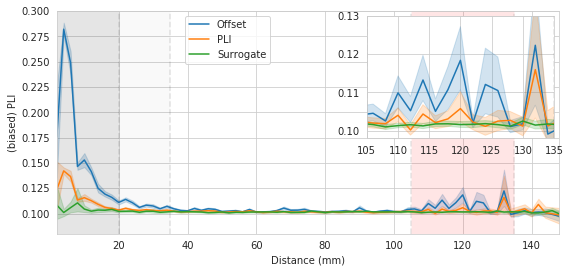

In [90]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

xmin_inter = 105
xmax_inter = 135

fig, ax = plt.subplots(1, 1, figsize=(9.0, 4.10))

tmp_dat = dat.copy()
tmp_dat.loc[tmp_dat["type"] == "pli", "type"] = "PLI"
tmp_dat.loc[tmp_dat["type"] == "offset", "type"] = "Offset"
tmp_dat.loc[tmp_dat["type"] == "surrogate", "type"] = "Surrogate"

sns.lineplot(x="dist_bin", y="con", hue="type", data=tmp_dat, ax=ax)

ax.set_xlabel("Distance (mm)")
ax.set_ylabel("(biased) PLI")  

xmin = np.min(dat["dist_bin"][dat["type"] != "surrogate"])
xmax = np.max(dat["dist_bin"][dat["type"] != "surrogate"])
ax.set_xlim(xmin, xmax)
ax.axvline(x=xmin_inter, linestyle="--", color="k", alpha=0.1)
ax.axvline(x=xmax_inter, linestyle="--", color="k", alpha=0.1)
ax.axvline(x=20, linestyle="--", color="k", alpha=0.1)
ax.axvline(x=35, linestyle="--", color="k", alpha=0.1)
ax.set_ylim(0.08, 0.3)

ax.fill_between([xmin_inter, xmax_inter], [0, 0], [1, 1], facecolor='red', alpha=0.1)

ax.fill_between([0, 20], [0, 0], [1, 1], facecolor='black', alpha=0.1)
ax.fill_between([20, 35], [0, 0], [1, 1], facecolor='black', alpha=0.025)

handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles[1:], labels=labels[1:])
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
bb.x0 -= 0.16
bb.x1 -= 0.16
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

# Adding and inset
axins = inset_axes(ax, width=2.6, height=1.7)

xmin_inter = 105
xmax_inter = 135

sns.lineplot(x="dist_bin", y="con", hue="type", data=dat, ax=axins)

xmin = np.min(dat["dist_bin"][dat["type"] != "surrogate"])
xmax = np.max(dat["dist_bin"][dat["type"] != "surrogate"])
axins.set_xlim(xmin_inter, xmax_inter)
axins.axvline(x=xmin_inter, linestyle="--", color="k", alpha=0.1)
axins.axvline(x=xmax_inter, linestyle="--", color="k", alpha=0.1)
axins.set_ylim(0.098, 0.13)
axins.legend().set_visible(False)
axins.set_xlabel("")
axins.set_ylabel("")  



fig.savefig(figure_path / '1.a-pli-vs-distance.png', dpi=200, figsize=(4.0, 2.05))

(0.095, 0.15)

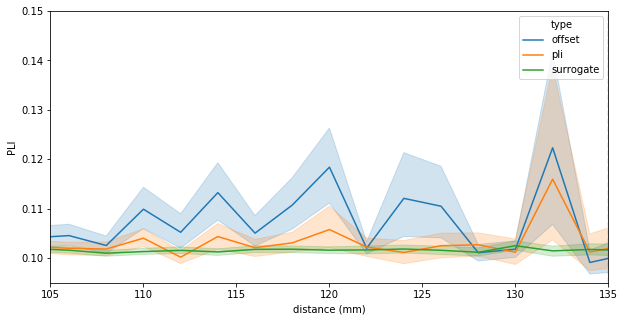

In [19]:
xmin_inter = 105
xmax_inter = 135

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(x="dist_bin", y="con", hue="type", data=dat, ax=ax)

ax.set_xlabel("distance (mm)")
ax.set_ylabel("PLI")  

xmin = np.min(dat["dist_bin"][dat["type"] != "surrogate"])
xmax = np.max(dat["dist_bin"][dat["type"] != "surrogate"])
ax.set_xlim(xmin_inter, xmax_inter)
ax.axvline(x=xmin_inter, linestyle="--", color="k", alpha=0.1)
ax.axvline(x=xmax_inter, linestyle="--", color="k", alpha=0.1)
ax.set_ylim(0.095, 0.15)

In [20]:
bias = np.mean(means_between["con"])
bias_sd = np.std(means_between["con"])
print("Bias: {} +/- {} (N={})".format(bias, bias_sd, len(dat["con"][dat["type"] == "surrogate"])))

dat["debiased_con"] = dat["con"] - bias


Bias: 0.10164204986469934 +/- 0.01321799858092199 (N=78303)


In [21]:
data_tmp = dat[(dat["dist_bin"] > xmin_inter) & (dat["dist_bin"] < xmax_inter)]
dat_tmp2 = data_tmp[data_tmp["type"] != "surrogate"]\
                .pivot_table(index=['dist_bin', "ch_names1", "ch_names2", "state"], 
                             columns='type', values="debiased_con")\
                .reset_index()
dat_tmp2 = add_dist_homologuous(dat_tmp2.dropna())

/home/christian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
dat_tmp2["chan_type1"] = ch_info2.loc[dat_tmp2["ch_names1"], "Electrode type"].values
dat_tmp2["chan_type2"] = ch_info2.loc[dat_tmp2["ch_names2"], "Electrode type"].values

dat_tmp2["region_lobe1"] = [region_info.loc[ch_info2.loc[ch_name1, "Region"], "Lobe"] 
                           for ch_name1, ch_name2 in dat_tmp2[["ch_names1", "ch_names2"]].values]

dat_tmp2["region_lobe2"] = [region_info.loc[ch_info2.loc[ch_name2, "Region"], "Lobe"] 
                           for ch_name1, ch_name2 in dat_tmp2[["ch_names1", "ch_names2"]].values]

dat_tmp2["region_name1"] = [region_info.loc[ch_info2.loc[ch_name1, "Region"], "Region name"] 
                           for ch_name1, ch_name2 in dat_tmp2[["ch_names1", "ch_names2"]].values]

dat_tmp2["region_name2"] = [region_info.loc[ch_info2.loc[ch_name2, "Region"], "Region name"] 
                           for ch_name1, ch_name2 in dat_tmp2[["ch_names1", "ch_names2"]].values]

dat_tmp2["subject"] = ch_to_subjects(dat_tmp2["ch_names1"])

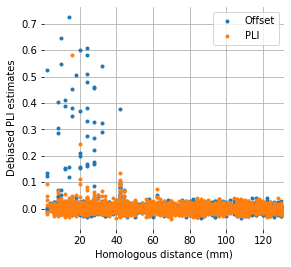

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(4.3, 4.08))
ax.plot(dat_tmp2["dist_bin_homo"], dat_tmp2["offset"], ".", label="Offset")
ax.plot(dat_tmp2["dist_bin_homo"], dat_tmp2["pli"], ".", label="PLI")
ax.legend()
ax.set_xlim(np.min(dat_tmp2["dist_bin_homo"])-1.5, np.max(dat_tmp2["dist_bin_homo"])+1.5)
ax.set_xlabel("Homologous distance (mm)")
ax.set_ylabel("Debiased PLI estimates")
ax.grid(True)
ax.set(frame_on=False);

fig.savefig(figure_path / '1.b-pli-vs-homologous-distance.png', dpi=200, figsize=(2.15, 2.04))

In [24]:
dat_tmp3 = dat_tmp2[dat_tmp2["offset"] > 0.1]
assert(np.all(dat_tmp3["chan_type1"] == dat_tmp3["chan_type2"]))
del dat_tmp3["chan_type2"]

In [25]:
if np.all(dat_tmp3["region_name1"] == dat_tmp3["region_name2"]):
    print("All offset-PLI > 1 in the target region are for homologous pairs.")

All offset-PLI > 1 in the target region are for homologous pairs.


#### Those zero-lagged inter-hemispheric connectivity are all within corresponding regions

In [26]:
print("Number of significantly zero-lag connected homologous pairs:", len(dat_tmp3["region_name1"]))

Number of significantly zero-lag connected homologous pairs: 46


In [27]:
dat_tmp4 = dat_tmp3.sort_values(["state", "region_lobe1", "region_name1"])
del dat_tmp4["region_name2"]
del dat_tmp4["region_lobe2"]
del dat_tmp4["ch_names1"]
del dat_tmp4["ch_names2"]

In [28]:
for label, variable in zip(["lobe", "region", "channel type", "state"], 
                           ["region_lobe1", "region_name1", "chan_type1", "state"]):
    print("################# {} ##################".format(label))
    print("{} split for significant homologous pairs:".format(label))
    signif = {lobe:nb for lobe, nb in zip(*np.unique(dat_tmp4[variable], return_counts=True))}
    print(signif)
    print("")

    print("{} split for the total number of homologous pairs:".format(label))
    total = {region:nb for region, nb in zip(*np.unique(dat_tmp2[dat_tmp2["region_name1"] == 
                                                               dat_tmp2["region_name2"]][variable], 
                                                      return_counts=True))}
    print(total)
    print("")

    print("Percentage of significant homologous pairs per {}:".format(label))
    percent = {lobe:signif[lobe]/total[lobe]*100 for lobe in signif}
    print(percent)
    print("")
    
    print("Percentage split of significant homologous pairs per {}:".format(label))
    percent = {lobe:signif[lobe]/np.sum(list(signif.values()))*100 for lobe in signif}
    print(percent)
    print("")
    
    print("Percentage split of total homologous pairs per {}:".format(label))
    percent = {lobe:signif[lobe]/np.sum(list(total.values()))*100 for lobe in signif}
    print(percent)
    print("")    

################# lobe ##################
lobe split for significant homologous pairs:
{'Frontal': 8, 'Parietal': 1, 'Temporal': 37}

lobe split for the total number of homologous pairs:
{'Frontal': 41, 'Parietal': 4, 'Temporal': 229}

Percentage of significant homologous pairs per lobe:
{'Frontal': 19.51219512195122, 'Parietal': 25.0, 'Temporal': 16.157205240174672}

Percentage split of significant homologous pairs per lobe:
{'Frontal': 17.391304347826086, 'Parietal': 2.1739130434782608, 'Temporal': 80.43478260869566}

Percentage split of total homologous pairs per lobe:
{'Frontal': 2.9197080291970803, 'Parietal': 0.36496350364963503, 'Temporal': 13.503649635036496}

################# region ##################
region split for significant homologous pairs:
{'Middle temporal gyrus': 12, 'Opercular part of inferior frontal gyrus': 1, 'Planum temporale': 12, 'Precentral gyrus': 7, 'Superior temporal gyrus': 13, 'Supramarginal gyrus': 1}

region split for the total number of homologous pa

In [29]:
subjects, counts = np.unique(dat_tmp2[dat_tmp2["region_name1"] == dat_tmp2["region_name2"]]["subject"], 
                             return_counts=True)

In [30]:
subjects_signif, counts_signif = np.unique(dat_tmp4["subject"], return_counts=True)

counts_df = pd.DataFrame({"subject":subjects, "counts":counts}).merge(pd.DataFrame({"subject":subjects_signif, 
                                                                        "counts_signif":counts_signif}), 
                                                          on="subject", how="outer").fillna(0)

In [31]:
counts_df["percentage"] = counts_df["counts_signif"]/counts_df["counts"]
counts_df["counts_signif"] = counts_df["counts_signif"].astype(int)
counts_df

,subject,counts,counts_signif,percentage
0,29,30,9,0.300000
1,40,9,6,0.666667
2,69,4,2,0.500000
3,75,3,0,0.000000
4,84,92,10,0.108696
5,88,104,9,0.086538
6,89,4,0,0.000000
7,94,12,6,0.500000
8,106,16,4,0.250000


/home/christian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


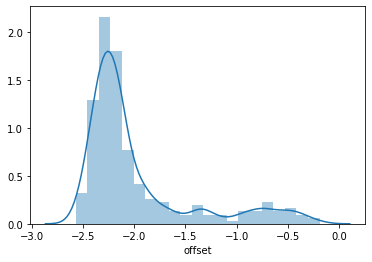

In [32]:
data_tmp = dat[(dat["dist_bin"] > xmin_inter) & (dat["dist_bin"] < xmax_inter)]
dat_tmp6 = data_tmp[data_tmp["type"] != "surrogate"]\
                .pivot_table(index=['dist_bin', "ch_names1", "ch_names2", "state"], 
                             columns='type', values="con")\
                .reset_index()
dat_tmp6 = add_dist_homologuous(dat_tmp6.dropna())

dat_tmp6["region_name1"] = [region_info.loc[ch_info2.loc[ch_name1, "Region"], "Region name"] 
                           for ch_name1, ch_name2 in dat_tmp6[["ch_names1", "ch_names2"]].values]

dat_tmp6["region_name2"] = [region_info.loc[ch_info2.loc[ch_name2, "Region"], "Region name"] 
                           for ch_name1, ch_name2 in dat_tmp6[["ch_names1", "ch_names2"]].values]

dat_tmp6["region_lobe1"] = [region_info.loc[ch_info2.loc[ch_name1, "Region"], "Lobe"] 
                           for ch_name1, ch_name2 in dat_tmp6[["ch_names1", "ch_names2"]].values]

dat_tmp6["chan_type"] = ch_info2.loc[dat_tmp6["ch_names1"], "Electrode type"].values

sns.distplot(np.log(dat_tmp6[dat_tmp6["region_name1"] == dat_tmp6["region_name2"]]["offset"]))

In [33]:
from scipy.stats import kruskal

dat_tmp7 = dat_tmp6[dat_tmp6["region_name1"] == dat_tmp6["region_name2"]]
dat_tmp7["offset"] -= bias
dat_tmp7["pli"] -= bias

/home/christian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/christian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [34]:
for label, variable in zip(["lobe", "region", "channel type", "state"], 
                           ["region_lobe1", "region_name1", "chan_type", "state"]):

    print("Effect of {} on offset-PLI".format(label))
    print(kruskal(*[dat_tmp7[dat_tmp7[variable] == var]["offset"]  for var in np.unique(dat_tmp7[variable])]))
    print("")

Effect of lobe on offset-PLI
KruskalResult(statistic=0.8803701188747645, pvalue=0.643917247092878)

Effect of region on offset-PLI
KruskalResult(statistic=29.0763407182225, pvalue=5.8846100583643416e-05)

Effect of channel type on offset-PLI
KruskalResult(statistic=6.52023602187603, pvalue=0.010665384814438166)

Effect of state on offset-PLI
KruskalResult(statistic=0.9387133883530798, pvalue=0.8160767347206912)



In [35]:
print("Effect of region on offset-PLI, once Planum Temporale data has been excluded".format(label))
print(kruskal(*[dat_tmp7[dat_tmp7["region_name1"] == region]["offset"]  
              for region in np.unique(dat_tmp7["region_name1"]) if region != "Planum temporale"]))

Effect of region on offset-PLI, once Planum Temporale data has been excluded
KruskalResult(statistic=2.769344212295357, pvalue=0.7354938232427223)


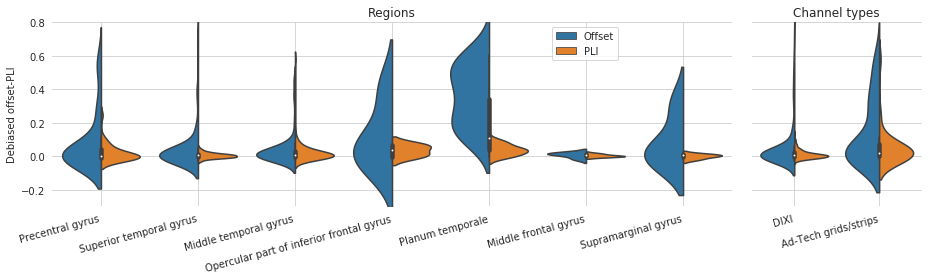

In [72]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sns.set_style("whitegrid")

f = plt.figure(figsize=(13.0, 4.0))

gs = gridspec.GridSpec(1, 2, width_ratios=[4,1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharey=ax1)

dat_tmp8 = pd.melt(dat_tmp7, id_vars=["region_name1", "chan_type"], value_vars=["pli", "offset"], value_name="con")
dat_tmp8.loc[dat_tmp8["chan_type"] == "D", "chan_type"] = "DIXI"
dat_tmp8.loc[dat_tmp8["chan_type"] == "G", "chan_type"] = "Ad-Tech grids/strips"
dat_tmp8.loc[dat_tmp8["type"] == "pli", "type"] = "PLI"
dat_tmp8.loc[dat_tmp8["type"] == "offset", "type"] = "Offset"

# Plot 1
v = sns.violinplot(x="region_name1", y="con", hue="type", data=dat_tmp8, 
                   width=0.8, inner="box", scale="count", split=True, 
                   hue_order=["Offset", "PLI"], ax=ax1)
ax1.grid(axis="both", zorder=0)

v.set_xticklabels(v.get_xticklabels(), rotation=15, horizontalalignment='right')
ax1.set_ylabel("Debiased offset-PLI")

ax1.set_xlabel("")
ax1.set_ylim(-0.2, 0.9)
ax1.set(frame_on=False)
leg = ax1.legend()
bb = leg.get_bbox_to_anchor().inverse_transformed(ax1.transAxes)
bb.x0 -= 0.16
bb.x1 -= 0.16

ax1.set_title("Regions")

# Plot 2
v = sns.violinplot(x="chan_type", y="con", hue="type", data=dat_tmp8, width=0.8, 
                   inner="box", scale="count", ax=ax2, split=True,
                   hue_order=["Offset", "PLI"])

ax2.grid(axis="both", zorder=0)
v.set_xticklabels(v.get_xticklabels(), rotation=15, horizontalalignment='right')
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_ylim(-0.3, 0.8)
ax2.set(frame_on=False)
ax2.legend().set_visible(False)
ax2.set_title("Channel types")

plt.setp(ax2.get_yticklabels(), visible=False)
f.tight_layout(w_pad=2.0)
leg.set_bbox_to_anchor(bb, transform = ax1.transAxes)

f.savefig(figure_path / '1.c-pli-distributions.png', dpi=200, figsize=(6.5, 1.6))

In [37]:
dat_tmp5 = dat_tmp2[dat_tmp2["offset"] < 0.1]
dat_tmp5["region_name1"] = [region_info.loc[ch_info2.loc[ch_name1, "Region"], "Region name"] 
                           for ch_name1, ch_name2 in dat_tmp5[["ch_names1", "ch_names2"]].values]

dat_tmp5["region_name2"] = [region_info.loc[ch_info2.loc[ch_name2, "Region"], "Region name"] 
                           for ch_name1, ch_name2 in dat_tmp5[["ch_names1", "ch_names2"]].values]

/home/christian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/christian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
print("Number of pairs in the target region: {}".format(dat_tmp2.shape[0]))
print("Number of non significant pairs in the target region: {}".format(len(dat_tmp5["region_name2"])))
print("Number of non significant homologous pairs in the target region: {}"
      .format(np.sum(dat_tmp5["region_name1"] == dat_tmp5["region_name2"])))
print("Number of homologous pairs in the target region: {}".format(np.sum(dat_tmp2["region_name1"] == 
                                                                          dat_tmp2["region_name2"])))
print("Number of non signifificant, non homologous pairs: {}".format(len(dat_tmp5["region_name2"]) - 
                                                                     np.sum(dat_tmp5["region_name1"] == dat_tmp5["region_name2"])))
nb_signif_pairs = dat_tmp2.shape[0]-len(dat_tmp5["region_name2"])
print("Number of significant pairs: {}".format(nb_signif_pairs))
print("Percentage of non significant pairs in the target region that are between homologous regions: {:.2f}%"
     .format(np.sum(dat_tmp5["region_name1"] == dat_tmp5["region_name2"])/len(dat_tmp5["region_name2"])*100))
print("Percentage of homologous pairs that are significant: {:.2f}%"
     .format(nb_signif_pairs/np.sum(dat_tmp2["region_name1"] == dat_tmp2["region_name2"]) *100))

Number of pairs in the target region: 3038
Number of non significant pairs in the target region: 2992
Number of non significant homologous pairs in the target region: 228
Number of homologous pairs in the target region: 274
Number of non signifificant, non homologous pairs: 2764
Number of significant pairs: 46
Percentage of non significant pairs in the target region that are between homologous regions: 7.62%
Percentage of homologous pairs that are significant: 16.79%


In [39]:
dat_tmp3_pli = dat_tmp2[dat_tmp2["pli"] > 0.1]

print("Number of significant (non offset) PLI connections:", len(dat_tmp3_pli["region_name1"]))

if np.all(dat_tmp3_pli["region_name1"] == dat_tmp3_pli["region_name2"]):
    print("All significant PLI connections are homologous.")

Number of significant (non offset) PLI connections: 6
All significant PLI connections are homologous.


In [40]:
rolled_tmp_5s = means_rolled_freq_5s.merge(dat_tmp3, 
                                           on=["state", "ch_names1", "ch_names2"])
rolled_tmp_1s = means_rolled_freq_1s.merge(dat_tmp3, 
                                           on=["state", "ch_names1", "ch_names2"])

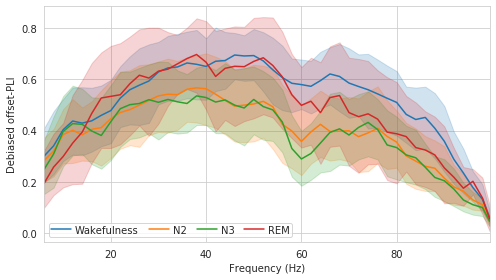

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(7.0, 4.0))

rolled_tmp_1s["debiased_con_roll"] = rolled_tmp_1s["con_roll"] -bias
sns.lineplot(x="freq", y="con_roll", hue="state", data=rolled_tmp_1s, ax=ax) 
ax.set_xlim(np.min(rolled_tmp_1s["freq"]), np.max(rolled_tmp_1s["freq"]))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], ncol=4, loc="lower left", 
          labelspacing=0.02, borderpad=0.2, handletextpad=0.4, columnspacing=1.0)
ax.set_ylabel("Debiased offset-PLI")
ax.set_xlabel("Frequency (Hz)")

plt.tight_layout()
fig.savefig(figure_path / '2.a-pli-vs-frequency.png', dpi=200, figsize=(2.0, 2.35))

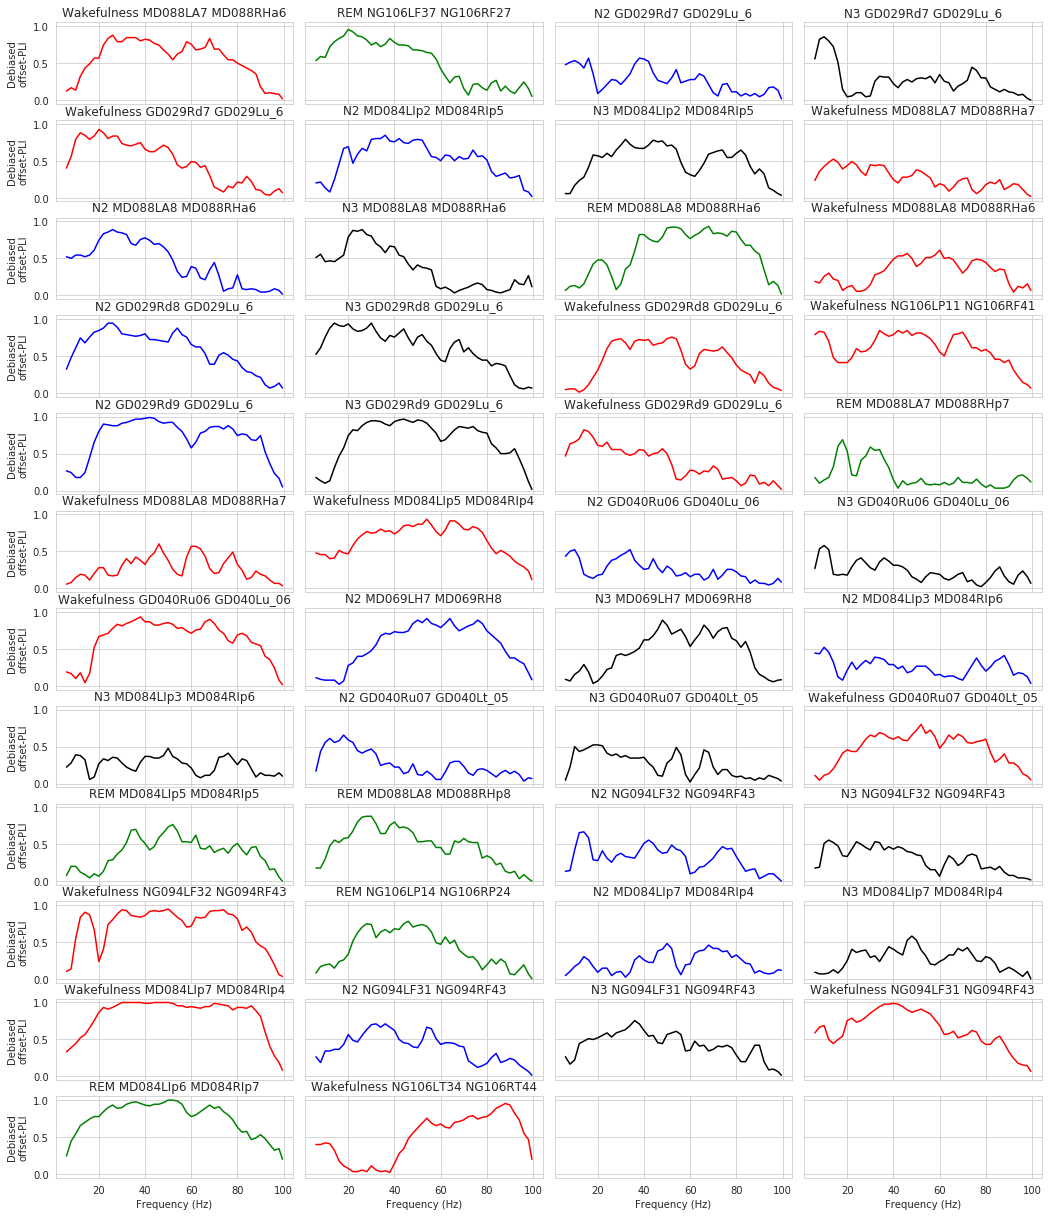

In [42]:
i = 0

color_dict = {"Wakefulness":"red",
              "REM":"green",
              "N2":"blue",
              "N3":"black",
              }

fig, axes = plt.subplots(12, 4, figsize=(15, 17), sharex=True, sharey=True)
for (state, ch_names1, ch_names2), ax in zip(dat_tmp3[["state", "ch_names1", "ch_names2"]].values, axes.ravel()):
    tmp_dat = rolled_tmp_1s[(rolled_tmp_1s["state"] == state) &
                            (rolled_tmp_1s["ch_names1"] == ch_names1) &
                            (rolled_tmp_1s["ch_names2"] == ch_names2)].sort_values("freq")
    ax.plot(tmp_dat["freq"], tmp_dat["con_roll"], color=color_dict[state]) 
    ax.set_title("{} {} {}".format(state, ch_names1, ch_names2))
    
    if int(i / 4) == i/4:
        ax.set_ylabel("Debiased\noffset-PLI")
    if i >= 44:
        ax.set_xlabel("Frequency (Hz)")
        
    i += 1
    
for ax in axes.ravel()[46:]:
    ax.set_xlabel("Frequency (Hz)")
    
fig.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.2)
fig.savefig(figure_path / 'S2-individual-pli-vs-frequency.png', dpi=200)

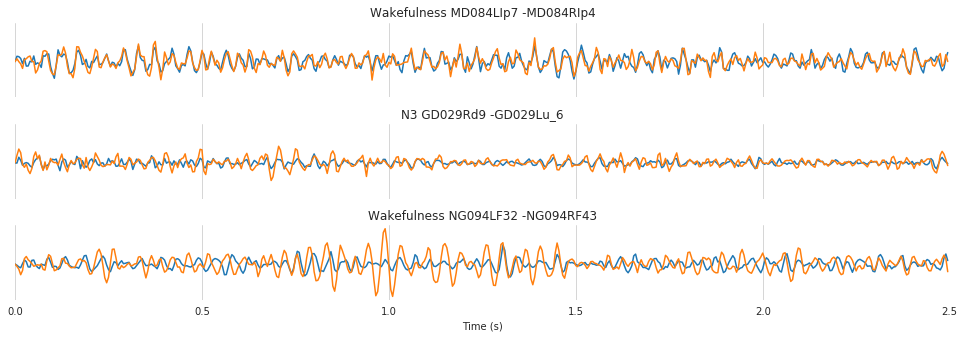

In [58]:
fig, axes = plt.subplots(3, 1, figsize=(13.5, 4.8), sharex=True, sharey=True )

raw_sig, channels = get_clean_data("Wakefulness")
sig1 = raw_sig[np.where(channels == "MD084LIp7"), :].flatten().astype(float)
sig1 = mne.filter.filter_data(sig1, 200, 20, 80, verbose=False)
sig2 = raw_sig[np.where(channels == "MD084RIp4"), :].flatten().astype(float)
sig2 = mne.filter.filter_data(sig2, 200, 20, 80, verbose=False)
axes[0].plot(np.arange(500)/200, sig1[:500]*10**6)
axes[0].plot(np.arange(500)/200, -sig2[:500]*10**6)
axes[0].set_xlim(0, 2.5)
axes[0].set_title("Wakefulness MD084LIp7 -MD084RIp4")

raw_sig, channels = get_clean_data("N3")
sig1 = raw_sig[np.where(channels == "GD029Rd9"), :].flatten().astype(float)
sig1 = mne.filter.filter_data(sig1, 200, 20, 80, verbose=False)
sig2 = raw_sig[np.where(channels == "GD029Lu_6"), :].flatten().astype(float)
sig2 = mne.filter.filter_data(sig2, 200, 20, 80, verbose=False)
axes[1].plot(np.arange(500)/200, sig1[:500]*10**6)
axes[1].plot(np.arange(500)/200, -sig2[:500]*10**6)
axes[1].set_xlim(0, 2.5)
axes[1].set_title("N3 GD029Rd9 -GD029Lu_6")

raw_sig, channels = get_clean_data("Wakefulness")
sig1 = raw_sig[np.where(channels == "NG094LF32"), :].flatten().astype(float)
sig1 = mne.filter.filter_data(sig1, 200, 20, 80, verbose=False)
sig2 = raw_sig[np.where(channels == "NG094RF43"), :].flatten().astype(float)
sig2 = mne.filter.filter_data(sig2, 200, 20, 80, verbose=False)
axes[2].plot(np.arange(500)/200, sig1[:500]*10**6)
axes[2].plot(np.arange(500)/200, -sig2[:500]*10**6)
axes[2].set_xlim(0, 2.5)
axes[2].set_title("Wakefulness NG094LF32 -NG094RF43")
axes[2].set_xlabel("Time (s)")

for ax in axes:
    ax.yaxis.set_visible(False)
    ax.set(frame_on=False)

plt.tight_layout()
fig.savefig(figure_path / '2.b-overlaid-signals.png', dpi=200)

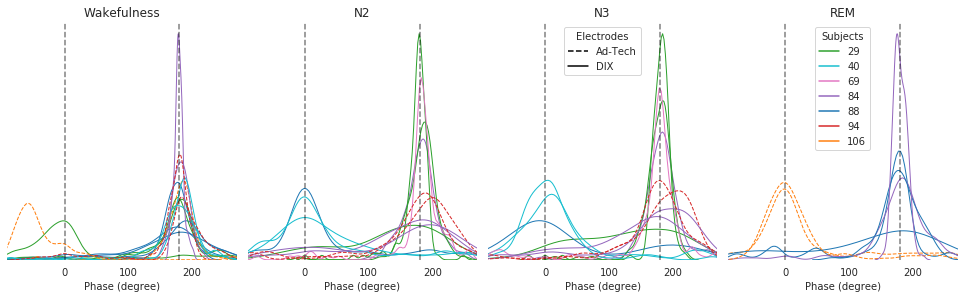

In [44]:
import matplotlib.lines as mlines
from matplotlib import mlab

np.random.seed(1)
current_palette = sns.color_palette()
np.random.shuffle(current_palette)
subject_color = {subject:color for color, subject in zip(current_palette, 
                                                         np.unique(dat_tmp3["subject"]))}

ele_type_linestyle = {"G": "dashed", 
                      "D": "solid"}

dat_tmp3.sort_values("state")
dat_kde = []

phase_dom_df = {"state":[], "ch_type":[], "index":[], "subject":[]}

fig, axes = plt.subplots(1, 4, figsize=(13.5, 4.25))

for state, ax in zip(states, axes):
    raw_sig, channels = get_clean_data(state)    
    tmp = dat_tmp3[dat_tmp3["state"] == state]
    
    
    
    for ch_names1, ch_names2, subject, ch_type in tmp[["ch_names1", "ch_names2", "subject", "chan_type1"]].values:
        sig1 = raw_sig[np.where(channels == ch_names1), :].flatten().astype(float)
        #sig1 = mne.filter.filter_data(sig1, 200, 20, 80, verbose=False)

        sig2 = raw_sig[np.where(channels == ch_names2), :].flatten().astype(float)
        #sig2 = mne.filter.filter_data(sig2, 200, 20, 80, verbose=False)

        (csd, f) = mlab.csd(sig1, sig2, NFFT=256, Fs=200, sides='default', scale_by_freq=False)
        angle = np.angle(csd, deg=True)
        angle[angle<-90] += 360

        p = sns.distplot(angle, hist=False, color=subject_color[subject], 
                         kde_kws=dict(linewidth=1, linestyle=ele_type_linestyle[ch_type]), 
                         ax=ax)
        dat_kde.append(p.get_lines()[0].get_data()[1])

        phase, amp = p.get_lines()[-1].get_data()
        phase_dom_df["index"].append((np.log10(amp[np.argmin(np.abs(phase - 180))]/
                                               amp[np.argmin(np.abs(phase))])))
        phase_dom_df["state"].append(state)
        phase_dom_df["ch_type"].append(ch_type)
        phase_dom_df["subject"].append(subject)
    
    ax.grid(False)
    ax.axvline(x=0, color="k", alpha=0.5, linestyle="dashed")
    ax.axvline(x=180, color="k", alpha=0.5, linestyle="dashed")
    ax.set_xlim(-90, 270)
    ax.set_xlabel("Phase (degree)")
    ax.set_title(state)

    ax.set(frame_on=False)
    plt.setp(ax.get_yticklabels(), visible=False);
    

handles = [mlines.Line2D([], [], color=subject_color[subject], label=subject)
           for subject in subject_color]

axes[3].legend(handles=handles)


handles = [mlines.Line2D([], [], color=subject_color[subject], label=subject)
           for subject in subject_color]
axes[3].legend(handles=handles, title="Subjects")

ele_labels = {"D":"DIX", "G": "Ad-Tech"}
handles = [mlines.Line2D([], [], color="k", linestyle=ele_type_linestyle[ele_type], label=ele_labels[ele_type])
           for ele_type in ele_type_linestyle]
axes[2].legend(handles=handles, title="Electrodes")
    
phase_dom_df = pd.DataFrame(phase_dom_df)

plt.tight_layout()

fig.savefig(figure_path / '2.c-phase-distribution.png', dpi=200)

In [45]:
phase_dom_df["dom_180"] = phase_dom_df["index"] > 0
pivot = pd.pivot_table(data=phase_dom_df, values="index", index=["state", "ch_type"], 
                       columns="dom_180", aggfunc="count").fillna(0)
pivot["percent"] = pivot[True]/(pivot[False] + pivot[True])
pivot

dom_180              False  True   percent
state       ch_type                       
N2          D          3.0   7.0  0.700000
            G          0.0   2.0  1.000000
N3          D          3.0   7.0  0.700000
            G          0.0   2.0  1.000000
REM         D          0.0   5.0  1.000000
            G          2.0   0.0  0.000000
Wakefulness D          1.0  10.0  0.909091
            G          1.0   3.0  0.750000

In [46]:
print("Percentage of phase difference dominance at 180 degrees, per subjects")
pivot = pd.pivot_table(data=phase_dom_df, values="index", index="subject", columns="dom_180", aggfunc="count").fillna(0)

pivot[True] / (pivot[True] + pivot[False])*100

Percentage of phase difference dominance at 180 degrees, per subjects


subject
29      88.888889
40      33.333333
69     100.000000
84     100.000000
88      77.777778
94     100.000000
106     25.000000
dtype: float64

In [47]:
print("Total for phase difference dominance at 180 degree:")
pivot.sum()[:2], pivot.sum()[1]/pivot.sum()[:2].sum()*100

Total for phase difference dominance at 180 degree:


(dom_180
 False    10.0
 True     36.0
 dtype: float64,
 78.26086956521739)

In [48]:
import scipy

print("P-value for equality of phase difference dominance:", 1-scipy.stats.binom.cdf(36, n=46, p=0.5))

P-value for equality of phase difference dominance: 2.0280180663689862e-05


In [49]:
bias_5s = np.mean(means_between_5s["con"])
bias_5s_sd = np.std(means_between_5s["con"])
bias_5s, bias_5s_sd, len(means_between_5s["con"])

(0.22522449152925272, 0.013789389222976744, 78303)

In [50]:
means_many_rolls_1s["debiased_con"] = means_many_rolls_1s["con_roll"] - bias
means_many_rolls_5s["debiased_con"] = means_many_rolls_5s["con_roll"] - bias_5s

/home/christian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide


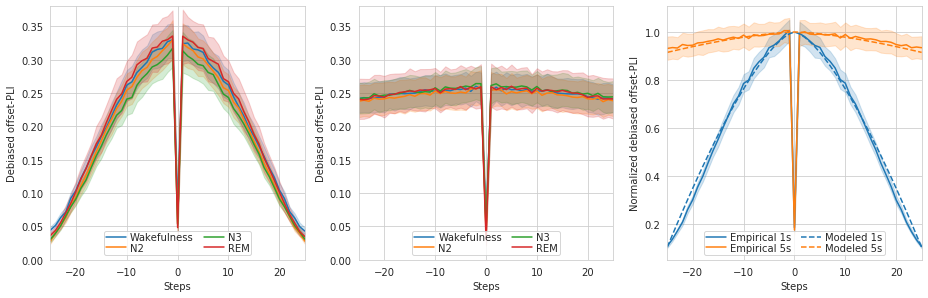

In [51]:
import numpy as np
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(13, 4.25))


tmp1 = means_many_rolls_1s.merge(means_rolled.loc[(means_rolled["dist"] > 35) & (means_rolled["con"] > bias + 0.1), 
                                            ["ch_names1", "ch_names2", "state"]], 
                          on=["ch_names1", "ch_names2", "state"])

sns.lineplot(x="step", y="debiased_con", hue="state", data=tmp1, ax=axes[0])

tmp2 = means_many_rolls_5s.merge(means_rolled.loc[(means_rolled["dist"] > 35) & (means_rolled["con"] > bias + 0.1), 
                                           ["ch_names1", "ch_names2", "state"]], 
                          on=["ch_names1", "ch_names2", "state"])

sns.lineplot(x="step", y="debiased_con", hue="state", data=tmp2, ax=axes[1])


norm_1s = np.mean(tmp1.loc[np.abs(tmp1["step"]) == 1, "debiased_con"])
norm_5s = np.mean(tmp2.loc[np.abs(tmp2["step"]) == 1, "debiased_con"])

#norm_1s = 0.3
#norm_5s = 0.3
colors = {}

tmp1["debiased_con"] /= norm_1s
sns.lineplot(x="step", y="debiased_con", data=tmp1, ax=axes[2], label="Empirical 1s")
colors[1] = axes[2].get_lines()[-1].get_c()

tmp2["debiased_con"] /= norm_5s
sns.lineplot(x="step", y="debiased_con", data=tmp2, ax=axes[2], label="Empirical 5s")
colors[5] = axes[2].get_lines()[-1].get_c()

fs = 200
steps = np.arange(-25, 26)
beta = 2.29
a = 12

for win in [1, 5]:
    dt = np.arange(win*fs)/fs
    freqs = 1/dt
    w = cumtrapz((1/freqs**beta)[::-1])/np.trapz(1/freqs**beta)
    # sqrt to account for the fact that the exponential relationship is computed on the power spectrum
    w = np.sqrt(np.concatenate(([0], w)))
    sig = [1- a*(np.abs(step)/(win*fs))*w[np.abs(step)] for step in steps]
    axes[2].plot(steps, sig, label="Modeled {}s".format(win), color=colors[win], linestyle="dashed")


for ax in axes[:2]:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:], ncol=2, loc="lower center", 
              labelspacing=0.02, borderpad=0.2, handletextpad=0.4, columnspacing=1.0)
    ax.set_ylabel("Debiased offset-PLI")
    ax.set_xlabel("Steps")
    ax.set_ylim(0, 0.38)

axes[2].set_ylabel("Normalized debiased offset-PLI")
axes[2].set_xlabel("Steps")
axes[2].legend(ncol=2, loc="lower center", labelspacing=0.02, borderpad=0.2, 
               handletextpad=0.4, columnspacing=1.0)

for ax in axes:
    ax.set_xlim(-25, 25)
    
fig.tight_layout()

fig.savefig(figure_path / 'S1.abc.c-pli-versus-step.png', dpi=200)

In [52]:
valid_pairs = dat_tmp7.loc[dat_tmp7["offset"] > 0.1, ["state", "ch_names1", "ch_names2"]]

all_data = []
all_ch_names = []
for state in states:
    data, data_ch_names = get_clean_data(state)
    valid_pairs.loc[valid_pairs["state"] == state, ["ch_names1", "ch_names2"]]
    
    ch_names = valid_pairs.loc[valid_pairs["state"] == state, ["ch_names1", "ch_names2"]].values.ravel()
    all_data.append(data[[list(data_ch_names).index(name) for name in ch_names], :])
    all_ch_names.extend(ch_names)
    
all_data = np.concatenate(all_data)
all_ch_names = np.array(all_ch_names)

In [53]:
N = all_data.shape[0]
epoch_inds = np.arange(0, N, 2)
nb_steps = 51
steps = np.arange(-25, 26)

con_dict = {}
for window_length in [1, 5]:
    nb_signals, nb_samples = all_data.shape
    nb_windows = int(nb_samples/sfreq/window_length)

    bands_low = np.arange(4.9, 100, 1/window_length)
    all_con = []
    for step in steps:    
        rolled_data = all_data.copy()
        rolled_data[epoch_inds, :] = np.roll(rolled_data[epoch_inds, :], step)
        rolled_epochs = np.array(np.hsplit(rolled_data, nb_windows))   


        ch_name1 = all_ch_names[epoch_inds]
        ch_name2 = all_ch_names[epoch_inds+1]

        con, freqs, times, n_epochs, n_tapers = \
            mne.connectivity.spectral_connectivity(rolled_epochs, 
                                                   method=con_method, 
                                                   fmin=bands_low,
                                                   fmax=bands_low+1/window_length,  
                                                   indices = (epoch_inds, epoch_inds+1),                                                
                                                   sfreq=sfreq, verbose=False,
                                                   faverage=True)  

        ds = pd.DataFrame({"con_roll": np.ravel(con),
                           "ch_names1": np.concatenate([[name]*len(bands_low) for name in ch_name1]), 
                           "ch_names2": np.concatenate([[name]*len(bands_low) for name in ch_name2]),
                           "freqs": list(np.concatenate(freqs))*int(N/2)})
        ds["step"] = step
        all_con.append(ds)      

    con_dict[window_length] = pd.concat(all_con)

<ipython-input-53-54afe2e291ef>:29: RuntimeWarning: fmin=4.900 Hz corresponds to 4.900 < 5 cycles based on the epoch length 1.000 sec, need at least 1.020 sec epochs or fmin=5.000. Spectrum estimate will be unreliable.
  faverage=True)
<ipython-input-53-54afe2e291ef>:29: RuntimeWarning: fmin=4.900 Hz corresponds to 4.900 < 5 cycles based on the epoch length 1.000 sec, need at least 1.020 sec epochs or fmin=5.000. Spectrum estimate will be unreliable.
  faverage=True)
<ipython-input-53-54afe2e291ef>:29: RuntimeWarning: fmin=4.900 Hz corresponds to 4.900 < 5 cycles based on the epoch length 1.000 sec, need at least 1.020 sec epochs or fmin=5.000. Spectrum estimate will be unreliable.
  faverage=True)
<ipython-input-53-54afe2e291ef>:29: RuntimeWarning: fmin=4.900 Hz corresponds to 4.900 < 5 cycles based on the epoch length 1.000 sec, need at least 1.020 sec epochs or fmin=5.000. Spectrum estimate will be unreliable.
  faverage=True)
<ipython-input-53-54afe2e291ef>:29: RuntimeWarning: fmin

<ipython-input-53-54afe2e291ef>:29: RuntimeWarning: fmin=4.900 Hz corresponds to 4.900 < 5 cycles based on the epoch length 1.000 sec, need at least 1.020 sec epochs or fmin=5.000. Spectrum estimate will be unreliable.
  faverage=True)
<ipython-input-53-54afe2e291ef>:29: RuntimeWarning: fmin=4.900 Hz corresponds to 4.900 < 5 cycles based on the epoch length 1.000 sec, need at least 1.020 sec epochs or fmin=5.000. Spectrum estimate will be unreliable.
  faverage=True)
<ipython-input-53-54afe2e291ef>:29: RuntimeWarning: fmin=4.900 Hz corresponds to 4.900 < 5 cycles based on the epoch length 1.000 sec, need at least 1.020 sec epochs or fmin=5.000. Spectrum estimate will be unreliable.
  faverage=True)
<ipython-input-53-54afe2e291ef>:29: RuntimeWarning: fmin=4.900 Hz corresponds to 4.900 < 5 cycles based on the epoch length 1.000 sec, need at least 1.020 sec epochs or fmin=5.000. Spectrum estimate will be unreliable.
  faverage=True)
<ipython-input-53-54afe2e291ef>:29: RuntimeWarning: fmin

In [54]:
con_dict[1.0]["debiased_con"] = con_dict[1.0]["con_roll"] - bias
con_dict[5.0]["debiased_con"] = con_dict[5.0]["con_roll"] - bias_5s

/home/christian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


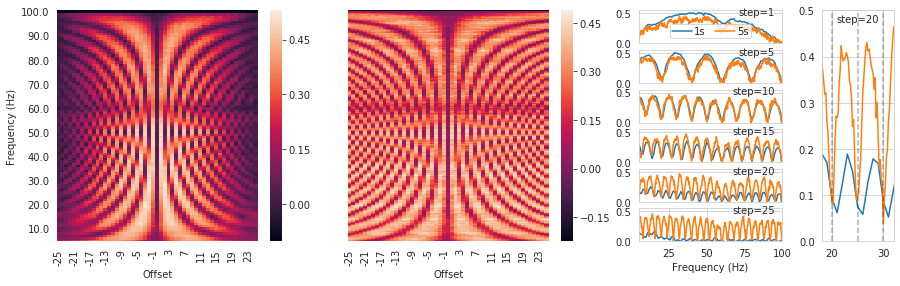

In [55]:
fig = plt.figure(figsize=(15, 4.25))
gs = fig.add_gridspec(6, 4, width_ratios=[0.35, 0.35, 0.2, 0.1], wspace=0.22)

axes = [fig.add_subplot(gs[:, 0]), fig.add_subplot(gs[:, 1])]

for w, ax in zip([1, 5], axes):
    pivot = pd.pivot_table(con_dict[w], index="freqs", columns="step", values="debiased_con")
    sns.heatmap(pivot, 
                xticklabels=pivot.columns, 
                ax=ax)
    ax.set_xlabel("Offset")
    ax.set_ylabel("Frequency (Hz)");
    ax.set_ylim(ax.get_ylim()[::-1])

    xticks = ax.get_xticklabels()
    for label in xticks:
        label.set_visible(False)
    for label in xticks[::4]:
        label.set_visible(True)
    for label in ax.get_yticklabels()[::2]:
        label.set_visible(False)
        
axes[1].set_yticks([])
axes[1].set_ylabel("")


#fig, axes = plt.subplots(6, 1, figsize=(4, 6), sharex=True, sharey=True)
axes = [fig.add_subplot(gs[i, 2]) for i in range(6)]

for step, ax in zip([1, 5, 10, 15, 20, 25], axes):
    for w in [1, 5]:
        x = con_dict[w].loc[con_dict[w]["step"] == step].groupby("freqs").mean()
        ax.plot(x.index, x["debiased_con"], label="{}s".format(w))
    ax.set_xlim(5, 100)
    ax.set_ylim(0, 0.55)
    if step != 25:
        ax.get_xaxis().set_visible(False)
    
    ax.text(.95,.85,"step={}".format(step),
        horizontalalignment='right',
        transform=ax.transAxes)    
    
    
axes[0].legend(ncol=2, labelspacing=0.02, borderpad=0.2, loc="lower center", 
               handletextpad=0.2, columnspacing=1.0)
axes[-1].set_xlabel("Frequency (Hz)")


ax = fig.add_subplot(gs[:, 3])
step= 20
for w in [1, 5]:
    x = con_dict[w].loc[con_dict[w]["step"] == step].groupby("freqs").mean()
    ax.plot(x.index, x["debiased_con"], label="{}s".format(w))

ax.text(.5,.95,"step=20",
    horizontalalignment='center',
    transform=ax.transAxes)

ax.set_xlim(18, 32)
ax.set_ylim(0, 0.5)
ax.axvline(x=20, linestyle="dashed", color="k", alpha=0.3)
ax.axvline(x=25, linestyle="dashed", color="k", alpha=0.3)
ax.axvline(x=30, linestyle="dashed", color="k", alpha=0.3)

plt.tight_layout()
fig.savefig(figure_path / 'S1.defg.c-pli-versus-step.png', dpi=200)

In [56]:
15**2*np.pi*29

20498.8920646734

In [57]:
from scipy.stats import ttest_1samp

# Two-tailed. Devide p-values by 2 for one tailed
percentage = [100, 100, 100,  89, 78, 33, 25]
ttest_1samp([100, 100, 100,  89, 78, 33, 25], popmean=50)

Ttest_1sampResult(statistic=2.0341504294754564, pvalue=0.08815561005265199)

In [91]:
# Cohen's d
(np.mean(percentage) - 50)/np.std(percentage)



0.8304384353796878